# Tutorial 6: Molecular Dynamics simulations

Molecular Dynamics (MD) is a workhorse of modern computational science. Not only did the field move beyond simple systems like gases or liquids, MD simulations are currently used at the atomic scale to study many (bio)physical/chemical processes. As seen in the lectures, MD simulations allow us to study the dynamcis and equilibrium properties of systems of particles, where we make use of classical physics. 

In this tutorial you will build a MD code from scratch, using pseudo-code provided by us. 

## Preliminary steps:

Perform the following tasks and answer the below questions for yourself to check whether you understand all of the important concepts.

- Read Chapter 18 on MD simulations, and check whether you can answer the following questions:
    1. What does the Lennard Jones potential describe, which physical terms does it originate from, and why is it convenient to use in our simulations?
    2. How do you calculate the inter-particle force from the Lennard-Jones potential?
    3. Why can you draw the initial velocities from a gaussian distribution?
    4. How can you calculate the kinetic energy and the (instantaneous) temperature?
    5. We simulate the particles inside a box. What are periodic boundary conditions, and how do you apply them (in other words: when you calculate the positions of particles that move outside of the box)?
    6. How do you calculate the time-evolution of a moving particle using the Verlet algorithm? When is the Verlet algorithm not accurate anymore?
    7. Why does it make sense to use reduced units in an MD simulation (instead of putting in all masses, length scales, etc..)? (Note: you will also use reduced units in this tutorial)
 


## Pseudocodes for a typical MD program
In this overview, we provide a rough pseudocode that outlines the different (essential) sub-functions of a molecular dynamics program. In the tutorial, you are asked to implement the functions for the Verlet algorithm (integrating the equations of motion) and the general program structure yourself. Animations, force functions and initialization are done by us.

### Pseudocode 1: Program structure
Most of the MD codes follow a structure like the `MD_program`-pseudocode given below. Typically, you would expect the following steps to occur in a MD program:

1. Set the relevant system parameters (think: temperature, number of particles, type of particles, density, timestep). The system is initialized using a dedicated function (see Pseudocode 2). This leads to the particles having a starting position and velocity within the simulation box. 
2. The forces on all the particles (Pseudocode 3) in the systems are determined using a force function (typically a Lennard Jones-potential). This function can also calculate the potential energy.
3. The velocities and positions are updated by integrating Newton's equations of motion (Pseudocode 4) using the Verlet algorithm.
4. This process repeats itself while iterating over time, where we save variables of interest (density, pressure, temperature, current coordinates and velocities or other physical quantities) every so many steps.

In reality, the force calculations can become very complicated, due to the many different types of forces involved (Electrostatics, covalent bonding, torsion within molecules). For today's problem, we will consider a simple atomic system that can be described purely through a Lennard Jones potential.


```
# Pseudocode 1: MD_program

call initialize() #initialize the simulation system, pseudocode 2
set time to 0
create arrays for storing properties

while time < maximum_time:
    call force()     #see pseudocode 3
    call integrate() #see pseudocode 4
    time+=1
    if time % some_value: # or use a counting variable
        store properties #calculate variables of interest
                         #and store them (but not for
                         #every timestep)
    
```

### Pseudocode 2: Initializing the MD simulation

It is important, just like in a real experiment, that the system is prepared properly. Otherwise, no adequate sampling of your quantity of interest is possible! In an MD simulation,system preparation usually consists of:

1. Assigning positions and velocities to a set number of particles within the simulation box. Particles shouldn't overlap, and should be well-distributed over the simulation volume (use for example a grid, or a random (x,y,z)-coordinate normalized by the size of the simulation box).
2. In order to form a simulation system at the right temperature that at the same time doesn't drift, you calculate the center-of-mass velocity of the system (the sum over all velocity vectors of all the particles) and the sum of the squared velocity vectors. 
3. You first correct for the drift in the system by subtracting it from the velcoities of the individual particles.
4. Following the kinetic definition of temperature, we can calculate a re-scaling factor that, upon multiplication with the velocities of the particles, sets the temperature of the system to the desired value.


```
#Pseudocode 2: initialize(number_of_particles,temp,dt,box_size)

#NOTE: THIS IS 1D! You need to repeat this for all 
# three dimensions. So work with 3x1 np arrays instead!

initialize variables sum_velocities, sum_velocities2

for i in number_of_particles:
    x(i)=assign_a_position(i)              #has to be within(0:L,0:L,0:L!)
    v(i)=random between -1 and +1 from a gaussian dist.
    sum_velocities += v(i)
    sum_velocities2 += v(i)**2

sum_velocities=/number_of_particles        #normalize COM vel.
sum_velocities2=/number_of_particles       #normalize COM vel**(2)

scalefactor=sqrt(3*temp/sum_velocities2)   #needed to set initial
                                           #temperature

for i in number_of_particles:
    v(i)=scalefactor*(v(i)-sum_velocities) #no net velocity


return x,v
```


### Pseudocode 3: Calculating the forces
The force calculation is often the most difficult and time-consuming aspect of the MD-simulation. Loops over all particle pairs that are within a certain distance are required, which makes the force calculation scale with at least $\propto N^2$. Due to its simplicity, a Lennard-Jones type of potential is mostly used in MD simulations, together with electrostatics (not in this tutorial, though).

A force calculation would consist of the following steps:

1. While looping over all particle pairs, calculate the distance (considering the boundaries!) between particles.
2. Based on a cut-off distance, judge whether forces need to be calculated (Note: this is the case for all non-covalent or non-bonded kind of physical interactions)
3. Calculate the forces between the particle pairs and apply Newton's third law (action = - reaction).
4. Calculate potential energies (the force is proprtional to the derivative of these anyways).

```
force(x,rc)

set pot_energy to 0 #the potential energy of the system
set forces to 0 #forces is a vector with same dimensions as x,v

#loop over all particle PAIRS: you run from the first to the
#pre-final particle, and from the second to the final particle.

for i in range(number_of_particles-1): 
    for j in range(i+1,number_of_particles): 
        xr=x(i)-x(j)
        xr=xr-box*nint(xr/box)   #nint is nearest integer. Periodic boundaries are in play!
        r2=xr**2       # NOTE: if you use 3D, use the vector length!        
        if r2 <= rc**2 # within cut-off = particles interact!
            r2i=1/r2   
            r6i=r2i**3   #dividing large numbers is slow!
            ff=48*r2i*r6i*(r6i-0.5) #alternative way of formulating force from LJ potential
            f(i)+=f(i)+ff*xr
            f(j)+=f(j)-ff*xr
            pot_energy+=4*r6i*(r6i-1)

return f,pot_energy
```

### Pseudocode 4: Integrating the equations of motion
After finding the forces on the particles, we can step the simulation system through time by integrating the equations of motion that describe it. To do so, we work with simple classes of integrating algorithms. One of the most often used algorithms to propagate the positions and velocities through time is the (Velocity-) Verlet algorithm. It works in the following way:

1. Calculate the forces (see the previous pseudocode).
2. Update the position using the velocity and forces at time $t$: $x(t+\Delta{t})=x(t)+\Delta{t}*v(t)+\frac{1}{2}\Delta{t}^2F(t)$. 
3. Calculate the forces again, but then using the updated positions (but correct for particles moving out of the box first)
4. Update the velocities: $v(t+\Delta{t})= v(t) + \frac{1}{2}\Delta{t}\Big(F(t)+F(t+\Delta{t})\Big)$

```
#NOTE: Also here the example is 1D. Use a 3x1 np.array!
integrate(x,v,f)
sum_velocities=0
sum_velocities2=0
for i in range(number_of_particles):

    #find new position, velocity using the VELOCITY Verlet algorithm.
    x(i)= x(i) + dt*v(i) + 0.5*timestep**2*f(i)
    
    #Periodic boundaries: if the particle moves 
    #outside of the box on either side, put it back in 
    #on the other side!
    
    loop over dimensions: #(repeat for x,y,z components)                
        if x(i,dimension) > box_size:
            x(i,dimension)-= box_size
        if x(i,dimension) < 0:
            x(i,dimension)+= box_size

#calculate new forces, use new position

f_new(i),dummy_energy = force() 

#update velocities, bookkeeping
for i in range(number_of_particles):

    v(i)= v(i) + 0.5*dt*(f(i)+f_new(i))
    

        
    #calculate the velocity, velocity**2 sums
    sum_velocities+=v(i)
    sum_velocities2+=v(i)**2
    

    
kin_energy=sum_velocities2/2


return x,v,kin_energy
```

## Exercises

We already wrote several of the functions and visualizations for you. Your task for this tutorial will be to write the `integrate` function and the general `run_MD_simulation` function. **Before you start, make sure to check the `initialize` and the `force` functions, such that you know what datatypes the positions, velocities and forces are stored in! You can even call the `initialize` and `force` functions once. 

### Part one: Writing the `integrate` function
*Note: See the pseudocode!*

1. Your aim is to apply the Velocity Verlet algorithm (Pseudocode 4). Create the `integrate` function with inputs `positions, velocities, forces, dt, box_size` and have it return the position, velocity, forces, kinetic energy and potential energy.
2. Apply the velocity verlet algorithm to update the positions.
3. You need to check whether the position update does not lead to particles moving outside of the box. You can make a loop over the dimensions (there are three), and check for which elements in the `positions` array the particle has moved outside of the box (i.e. any coordinate is below 0 or larger than `box_size`). You can use `np.where(position[:,dimension] > box_sizeor )` for example.
4. After correcting the positions, make a call to the `force_function()`-function to calculate the intermediate forces. Then, update the velocities. If you do this right (making use of the properties of  `numpy` arrays), then no loops are necessary.
5. With the updated forces in place, update the velocities using the final call of the Velocity Verlet algorithm.
6. Calculate the kinetic energy by summing over all the squared components of the velocity vector: $\sum_i \frac{1}{2}mv_i^2$
7. Make your function return the positions, velocities, (new) forces, kinetic energies, and potential energies.


### Part two: Writing the `run_MD_simulation` function
You have all ingredients for performing a MD simulation. Let's get going (but don't forget to check the pseudocode):

1. Your function should take the arguments that define the parameters for your simulation: `num_particles, initial_temp, box_size, dt, time_max`, and ultimately should return arrays containing the time-values,  different kind of energies (kinetic, potential, total), temperature, and of course lists containing the coordinate and velocity arrays for all time steps.
2. Within your function, initialize the particle positions, velocities and kinetic energy using the `initialize` function.
3. Initialize the forces and potential energy for the first time step as well. Set time to 0, and calculate the initial temperature via $\sum_i \frac{mv_i^2}{3}$
4. Create `numpy`-arrays for all variables of interest (except for the coordinates and velocities) and assign your just-calculated initial values to their first element.
5. Repeat the above for the coordinates and the velocities, but instead append the `numpy`-arrays containing those to an empty list.
7. Use a `while`-construction to iterate over time (up until a maximum time `time_max`, updating the current `time`-value. Calculate the updated positions, energies etc. using the `integrate` function.
8. Store the variables by appending them to the correct array


### Exercises
1. Test the system for a small time step (i.e. 0.0001), a small number of particles (around 10), a relatively large box (10), and a short end-time (i.e. 1 or 0.1). Your code might take some time to run (MD simulations are notorious for the computing power that they require).
2. Investigate the effect of increasing your timestep: what happens?
3. By keeping the timestep small, investigate by comparing the graphs of the different types of energies whether energy is conserved (averaged over a long time), and whether there is a transfer of energy between different the kinetic and potential components.
4. What happens if you crowd the box with many particles (i.e. increasing the particle number significantly)? Which types of energy significantly change in terms of their magnitudes?

### Conceptual questions:
1. Why do we choose to use a cut-off for the Lennard-Jones interactions? 
    - What happens if we make the cut-off very small (try it!), and what happens if we make the cut-off very large?   
    - What do you expect to happen when the cut-off becomes larger than half of the box size while simulating a large molecule?
    - Why did we include the correction term for the potential energy calculation?
2. Does the Verlet algorithm conserve momentum?
3. This simulation took place in the microcanonical ensemble. How can you tell?

In [2]:
import numpy as np
import random as rd

def initialize(num_particles, temp, box_size, dt):
    '''
    initialize(num_particles,temp_box_size,dt):
    returns:
            -an array with particle positions (dimension num_particles by 3)
            -an array with velocities (dimension nm_particles by 3)
            - the above is set within a box of box_size*box_size*box_size
            - the above is set at a temperature t
    '''
    
    #initialize positions (random normalized by box size)
    #initialize velocities (random from gaussian, mean=0, std=1)
    positions=np.random.rand(num_particles,3)*box_size
    velocities=np.random.standard_normal(size=(num_particles,3))

    #calculate sum of all velocity vector components (x,y,z)
    #do the same for the squared version, and calculate the scaling factor.
    sum_velocities=np.sum(velocities,axis=0)/num_particles
    sum_velocities2=np.sum(velocities**2,axis=0)/num_particles
    scaling_factor=np.sqrt(3*temp/sum_velocities2)

    
    #set COM velocity to 0 by subtracting it, and re-scale to set the temperature
    velocities=(velocities-sum_velocities)*scaling_factor 

    #calculate previous positions
    positions_prev=positions-velocities*dt

    
    return positions, positions_prev, velocities
      
    
def force_function(positions, box_size, cut_off_distance = 5):
    '''
    force_function(positions, cut_off_distance=2.5, box_size):
    Calculates, using the LJ potential, the forces between particle pairs. These
    pairs have to be situated within the cut-off distance. The function takes 
    interactions into account that run through the periodic boundaries of the box.

    The function returns a num_particles*3 numpy array with forces, and the poten-
    tial energy.
    '''
  

    #initialize some parameters
    num_particles=len(positions)
    forces=np.zeros((num_particles,3),float)
    pot_energy=0.


    #loop over all particle PAIRS: you run from the first to the
    #pre-final particle, and from the second to the final particle.

    for i in range(num_particles-1): 
        for j in range(i+1,num_particles): 
            
            #check the inter-particle distance vector, and check PBC
            distance=positions[i]-positions[j]
            for dim in range(3): #periodic boundaries
                if abs(distance[dim])> 0.5*box_size:
                    distance[dim] = distance[dim]-np.sign(distance[dim]) * box_size

            
            r2=np.sqrt(np.sum(distance**2))   
            #within distance == particles interact!
            if r2 <= cut_off_distance: 
                
                #prevent overlapping particles:
                if r2 ==0.:
                    r2=0.001 
                
                #calculate higher powers via multiplication instead of division
                r2i=1/r2   
                r6i=r2i**3   
                
                rc2i=1/(cut_off_distance**2)
                rc6i=rc2i**3
                
                #Force comes from LJ potential
                ff=48*r2i*r6i*(r6i-0.5)   
                forces[i]+=ff*distance
                forces[j]-=ff*distance
                
                #potential energy
                pot_energy+=4*r6i*(r6i-1) - 4*(rc6i**2-rc6i) #subtracted E_c

    return forces,pot_energy


def integrate(positions, velocities, forces, dt, box_size):
    '''
    integrate(positions, velocities, forces, dt, box_size):

    
    '''
    #Ft, E_pot = force_function(positions, box_size)
    #positions += dt*velocities+(Ft*dt**2)/2
    positions += dt*velocities+(forces*dt**2)/2
    positions %= box_size
    new_forces, E_pot = force_function(positions, box_size)
    velocities += (dt/2) * (forces + new_forces)
    
    kin_energy = np.sum(velocities**2)/2
    potential_energy = E_pot
  

    #we need to check whether particles have moved out of the box. Therefore,
    #we loop over dimensions and have np.where return true/false whether this is
    #the case. Then, we put them back by a distance box_sim, depending on the di-
    #rection in which the particle left the box. 


    return positions, velocities, new_forces, kin_energy, potential_energy

In [5]:


def run_MD_simulation(num_particles, initial_temp, box_size, dt, time_max):
    temp = initial_temp
    t = 0
    positions, positions_prev, velocities = initialize(num_particles, temp, box_size, dt)
    forces, potential_energy = force_function(positions, box_size)
    
    time_array = []
    pot_energy_array = []
    temp_array = []
    coordinate_array = []
    kin_energy_array = []
    velocities_array = []
    tot_energy_array = []#[kin_energy_array[0]+pot_energy_array[0]]
    
    while t < time_max:
        positions, velocities, forces, kinetic_energy, potential_energy = integrate(positions, velocities, forces, dt, box_size)
        coordinate_array.append(positions.copy())
        velocities_array.append(velocities)
        pot_energy_array.append(potential_energy)
        kin_energy_array.append(kinetic_energy)
        temp_array.append(np.sum(velocities**2)/3)
        time_array.append(t)
        tot_energy_array.append((kinetic_energy + potential_energy))
        t+=dt
        
    return time_array, tot_energy_array, pot_energy_array, kin_energy_array, temp_array, coordinate_array, velocities_array


Text(0.5, 139.16666666666669, 'Time')

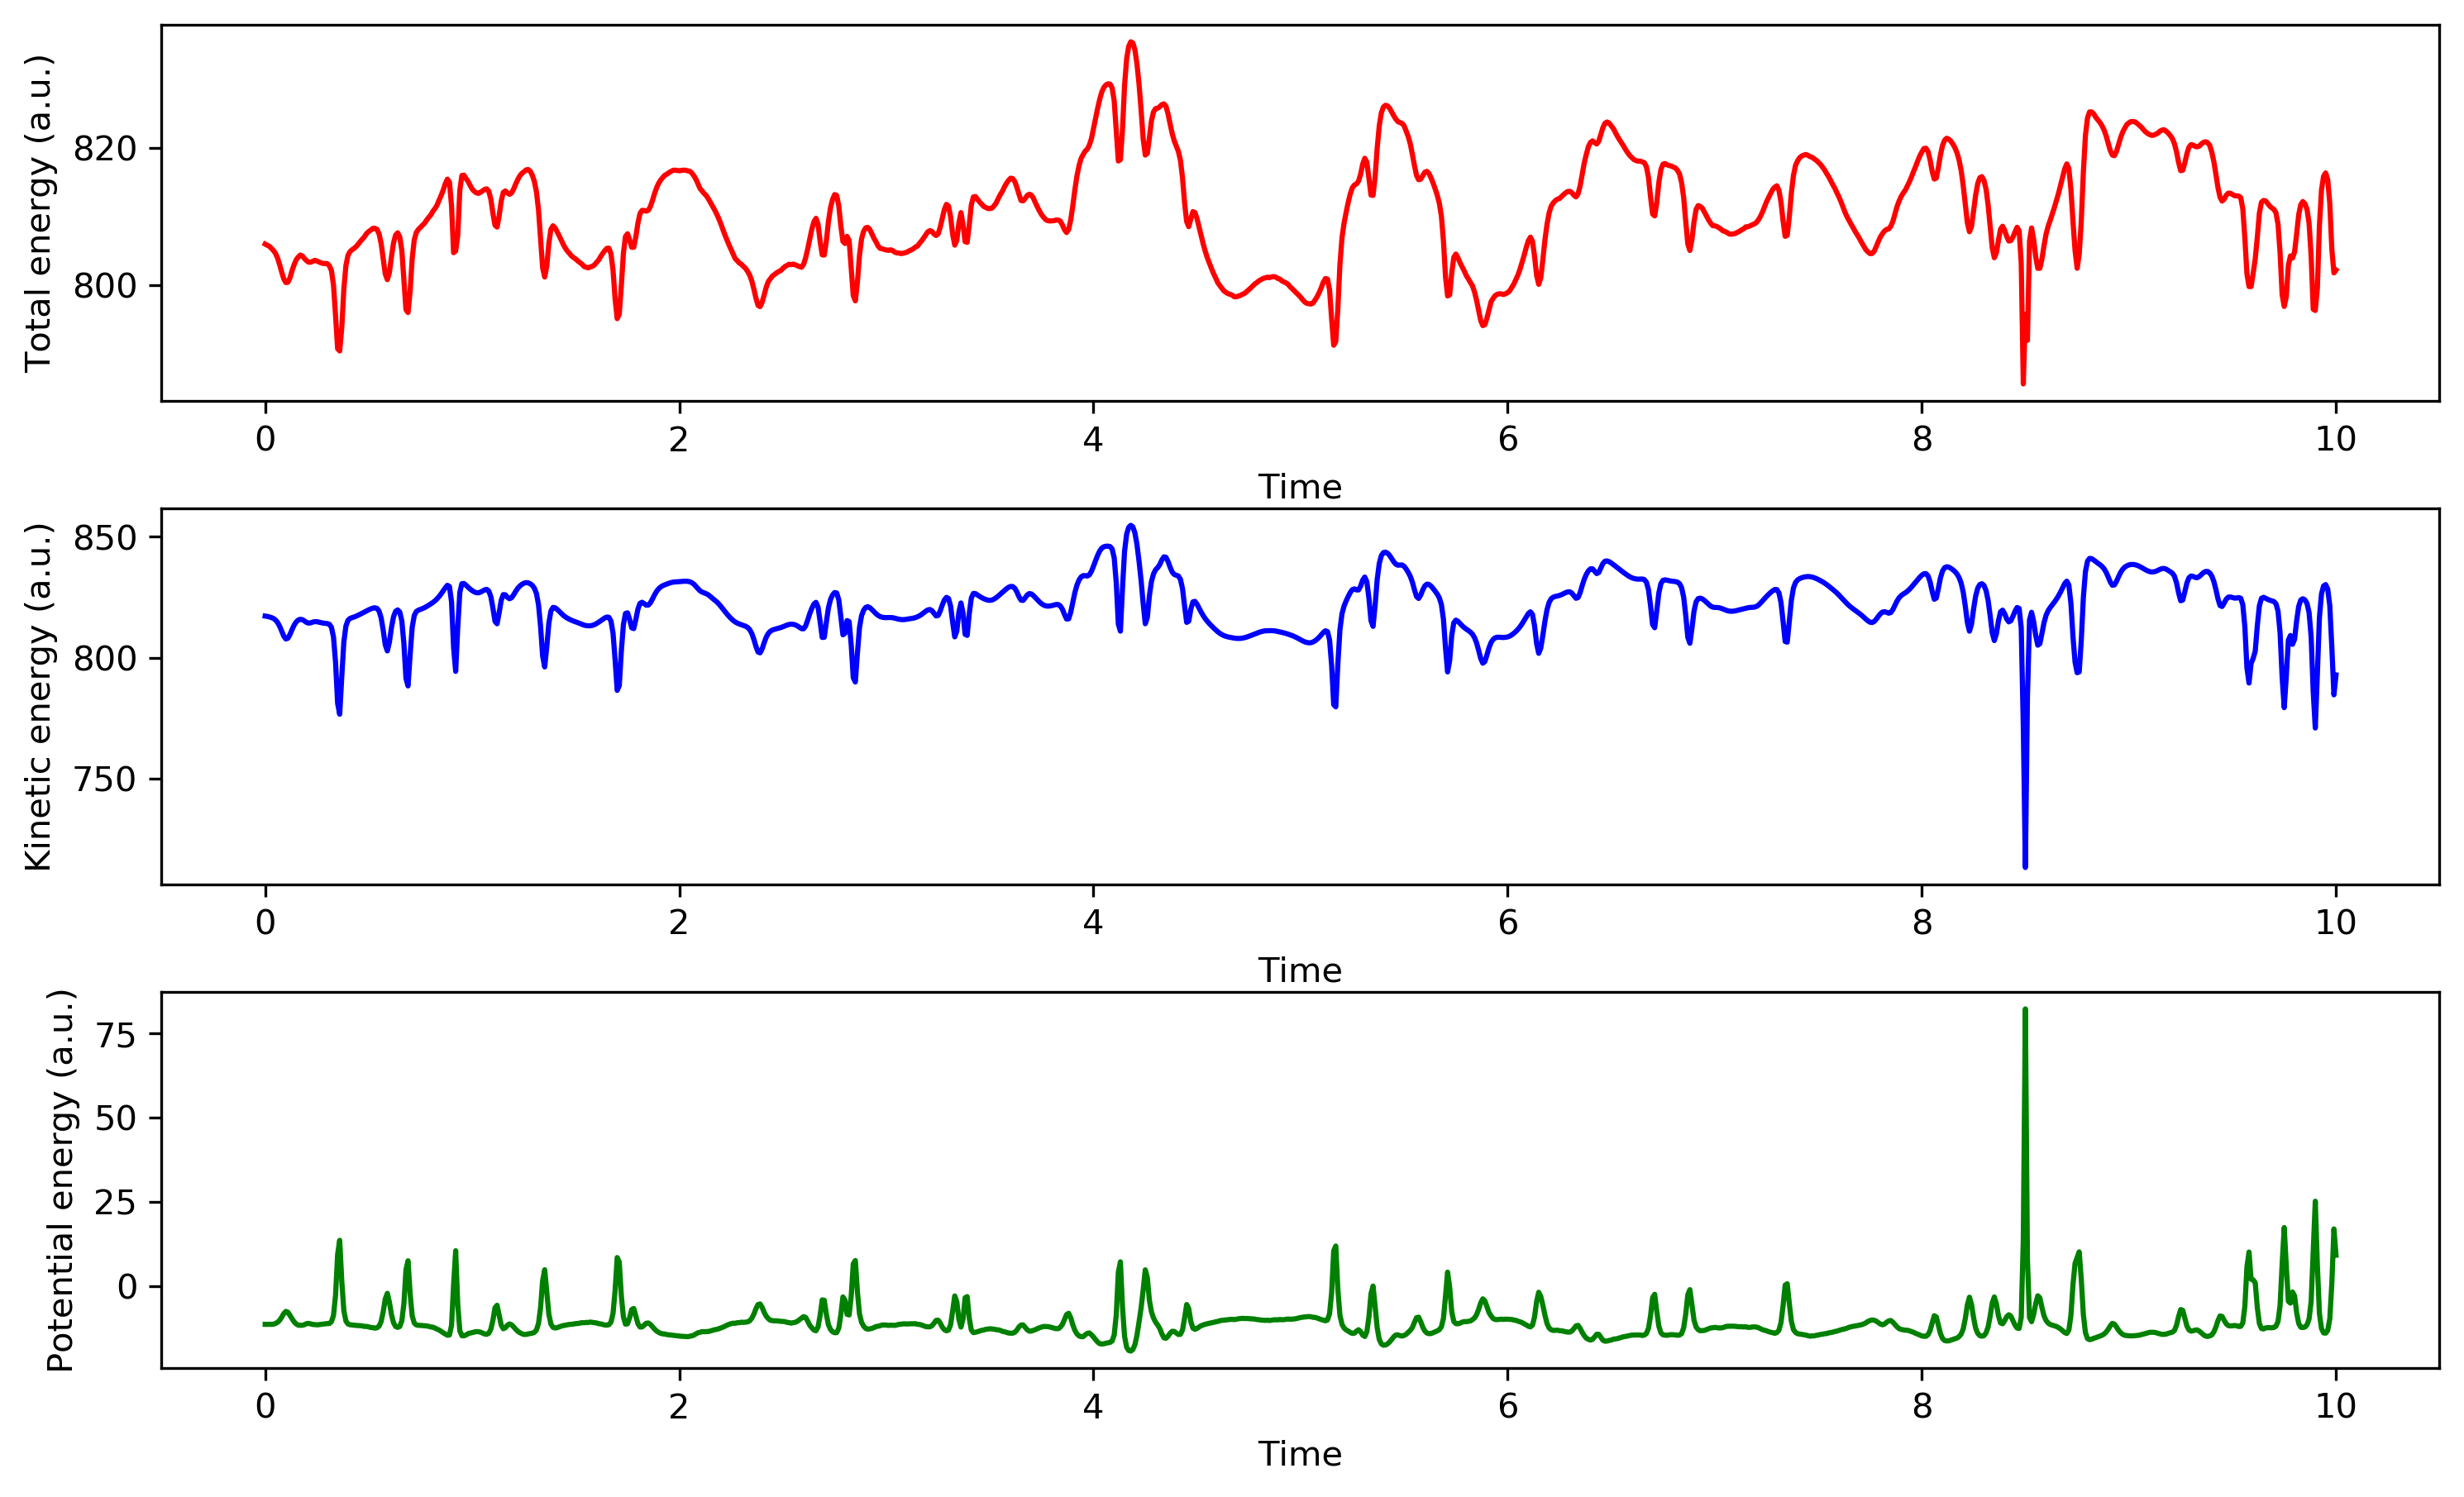

In [6]:
import numpy as np
import random as rd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline

#define your variables and run the MD simulation here (the things below are used for plotting)
num_particles, initial_temp, box_size, dt, time_max = 20, 10, 10, .01, 10
time_array, tot_energy_array, pot_energy_array, kin_energy_array, temp_array, coordinate_array, velocities_array = run_MD_simulation(num_particles, initial_temp, box_size, dt, time_max)


fig, ax = plt.subplots(nrows=3, ncols=1,dpi=300)
fig.set_size_inches(10,6)
plt.tight_layout()

ax[0].plot(time_array,tot_energy_array, lw=1.5, c='r')
ax[1].plot(time_array,kin_energy_array, lw=1.5, c='b')
ax[2].plot(time_array,pot_energy_array, lw=1.5, c='g')

ax[0].set_ylabel('Total energy (a.u.)')
ax[0].set_xlabel('Time')


ax[1].set_ylabel('Kinetic energy (a.u.)')
ax[1].set_xlabel('Time')

ax[2].set_ylabel('Potential energy (a.u.)')
ax[2].set_xlabel('Time')




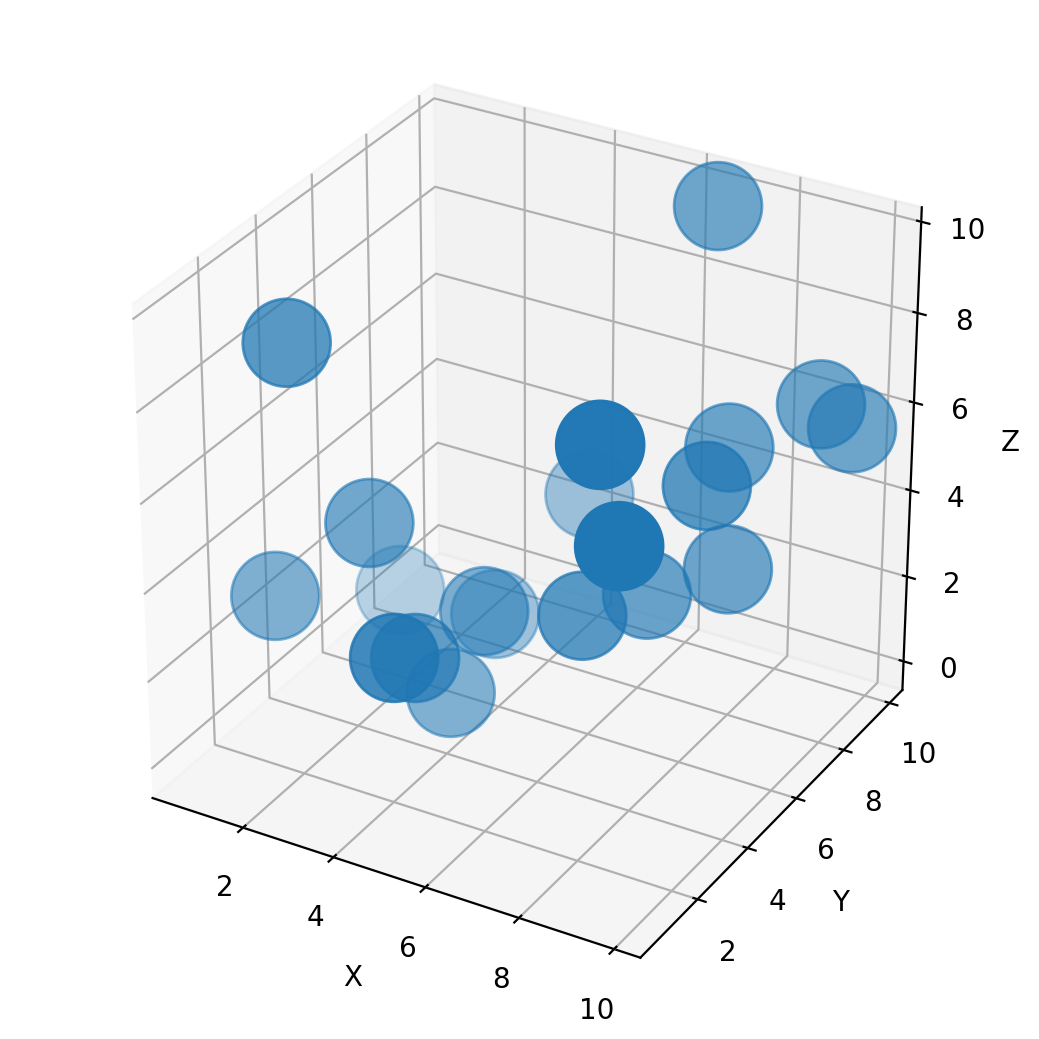

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


In [4]:
'''
This code cell is used to create a 3D animation of the particle positions over time. 
If you created your coordinate output correctly, then the animation should store a .gif file
of your trajectory. 
'''


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

def update(t):
    graph._offsets3d = (coordinates[t][:,0], coordinates[t][:,1], coordinates[t][:,2])
    return graph,
def init():
    line.set_data([], [])
    return line,

coordinates = coordinate_array
time = time_array

r = coordinates[0]
fig = plt.figure(figsize=(5,5),dpi=200)
ax = Axes3D(fig)
graph = ax.scatter(r[:,0],r[:,1], r[:,2],s=1000)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(time), interval = 50)
ani = animation.FuncAnimation(fig, update, frames=len(time), interval = 50)
plt.show()

ani.save('MD_animation.htm')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


IndexError: list index out of range

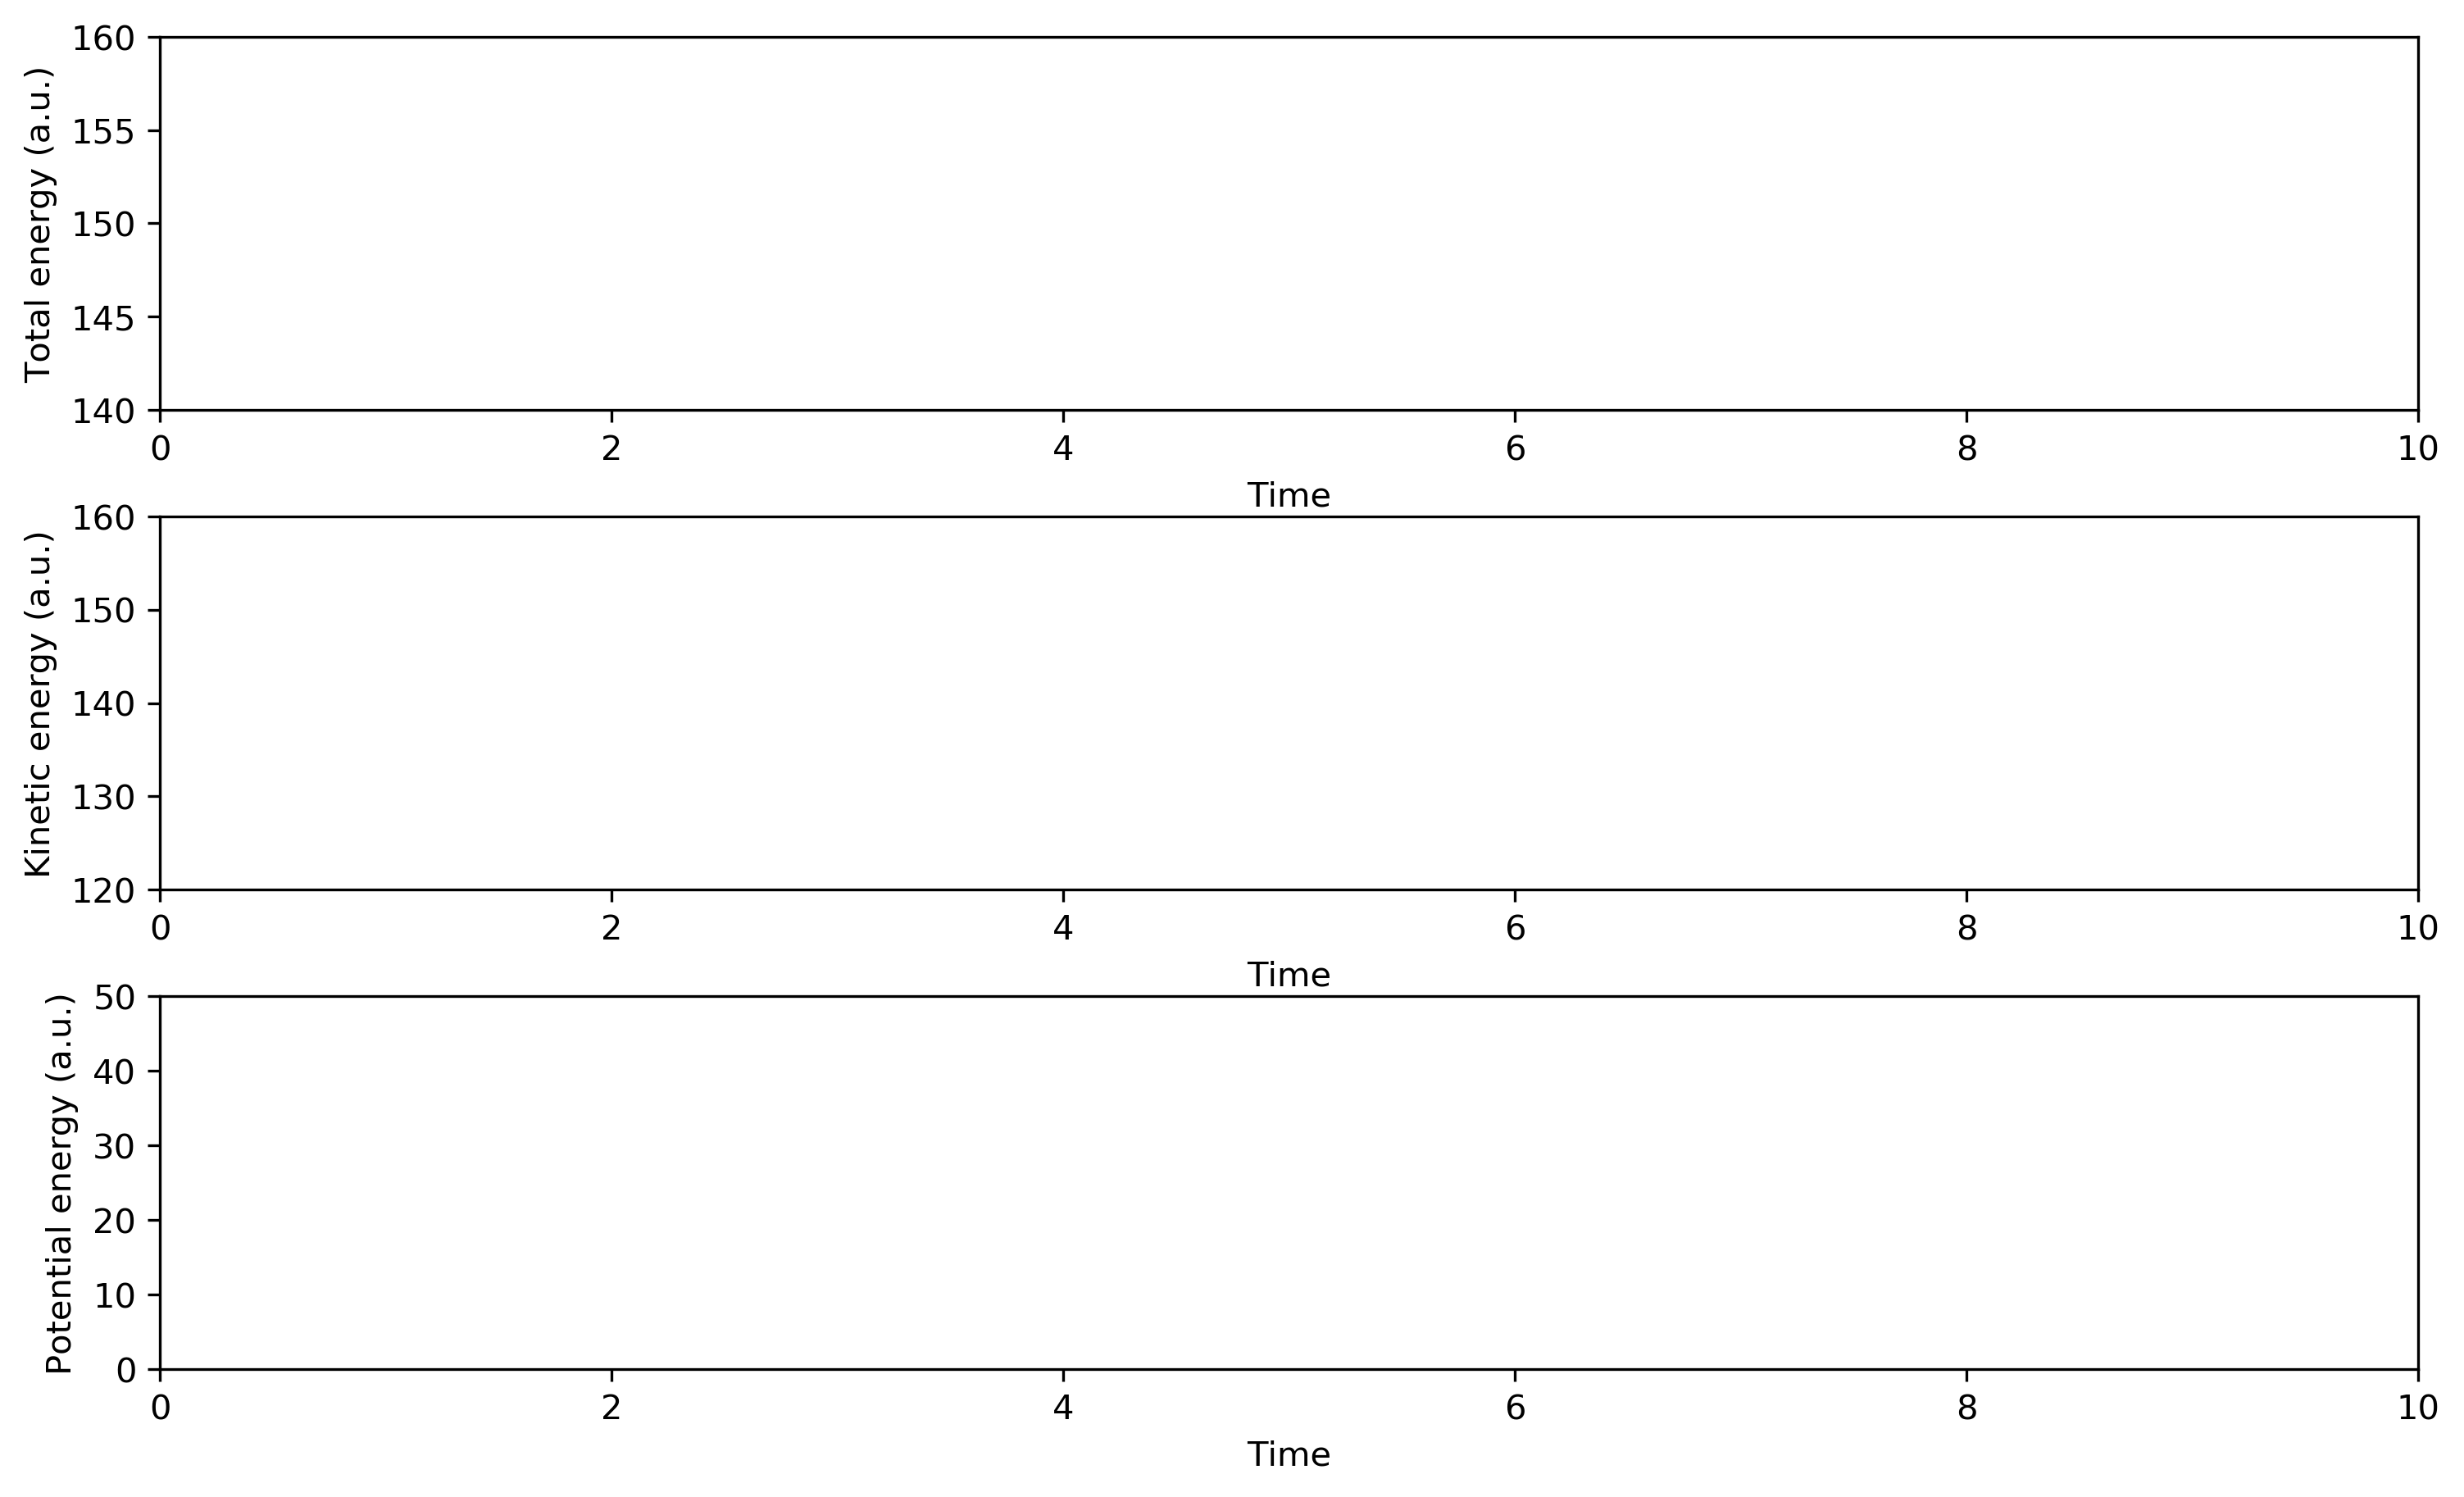

In [115]:
fig, ax = plt.subplots(nrows=3, ncols=1,dpi=300)
fig.set_size_inches(10,6)
plt.tight_layout()




line1, = ax[0].plot([], [], lw=1.5, c='r', zorder=0)
line2, = ax[1].plot([], [], lw=1.5, c='b', zorder=0)
line3, = ax[2].plot([], [], lw=1.5, c='g', zorder=0)

ax[0].set_ylabel('Total energy (a.u.)')
ax[0].set_xlabel('Time')
ax[0].set_xlim([0,time_max])
ax[0].set_ylim([140,160])

ax[1].set_ylabel('Kinetic energy (a.u.)')
ax[1].set_xlabel('Time')
ax[1].set_xlim([0,time_max])
ax[1].set_ylim([120,160])

ax[2].set_ylabel('Potential energy (a.u.)')
ax[2].set_xlabel('Time')
ax[2].set_xlim([0,time_max])
ax[2].set_ylim([0,50])

xdata,ydata=[],[]
xdata2,ydata2=[],[]
xdata3,ydata3=[],[]

def init():
    return line1,line2,line3,

def animate(i):
    xdata.append(time[i])
    xdata2.append(time[i])
    xdata3.append(time[i])
    
    ydata.append(energy_tot[i])
    ydata2.append(energy_kin[i])
    ydata3.append(energy_pot[i])
    
    line1.set_data(xdata, ydata)
    line2.set_data(xdata2,ydata2)
    line3.set_data(xdata3,ydata3)
    
    return line1, line2, line3,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(time), interval=20) 
anim.save('energies.htm') 

plt.show()



